## Defensive Technical Analysis strategy

The Defensive Technical Analysis strategy focuses on a more conservative approach by utilizing the Stochastic Oscillator and MACD indicators to generate buy and sell signals for the six largest tech stocks over the 2023 year period. The strategy employs the following indicators: 

Stochastic Oscillator: This is a momentum indicator that compares a particular closing price of a security to a range of its prices over a certain period. The strategy calculates the Stochastic Oscillator with a 21-day lookback period and a 5-day signal line period. A buy signal is generated when the Stochastic Oscillator is below 25, and a sell signal is generated when it is above 75. 

Moving Average Convergence Divergence (MACD): This is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. The MACD is calculated using the 12-day and 26-day EMAs, along with a 9-day signal line. A buy signal is generated when the MACD line crosses above the signal line, and a sell signal is generated when the MACD line crosses below the signal line. 

Relative Strength Index (RSI): RSI is a popular momentum oscillator used in technical analysis to measure the speed and change of price movements. RSI values range from 0 to 100, with readings above 70 indicating that an asset might be overbought (potentially signaling a price correction or reversal) and readings below 30 suggesting it may be oversold (indicating a potential upward reversal). The RSI helps traders identify potential entry and exit points by analyzing whether an asset's recent gains are too strong or too weak relative to recent losses.

The final buy or sell decision is made when both indicators agree on the same signal. When both indicators agree to sell a stock, and there are no buy signals for any other stocks on that same day, the sell transaction is executed and the proceeds from the sale are then evenly distributed among the remaining four stocks in the portfolio. When both indicators agree to sell a stock, and there is/are buy signals for other stock(s) on the same day, the proceeds from the sale are used to buy only the buy signal stock(s). 

In [354]:
import pandas as pd
import yfinance as yf  # Yahoo Finance API for fetching stock data
import matplotlib.pyplot as plt
import numpy as np

In [355]:
# Define the tech giant stocks in India and time period
tickers = ["TCS.NS", "INFY.NS", "HCLTECH.NS", "WIPRO.NS", "LTIM.NS", "TECHM.NS"]
start_date = '2022-12-01'
end_date = '2023-12-31'

initial_date = pd.Timestamp('2023-01-02')
initial_total_money_in_hand = 1000000

columns_to_drop = ['High', 'Low', 'Dividends', 'Stock Splits']
result_df = pd.DataFrame()

for each_stock in tickers:
    stock_data = yf.Ticker(each_stock)
    hist_stock_data = stock_data.history(start = start_date, end = end_date)
    hist_stock_data_copy = hist_stock_data.copy()
    hist_stock_data_copy = hist_stock_data_copy.drop(columns_to_drop, axis=1)
    hist_stock_data_copy.columns = [each_stock + '_' + col for col in hist_stock_data_copy.columns]
    result_df = pd.concat([result_df, hist_stock_data_copy], axis=1)

In [356]:
#calculate stochastic oscillator
def calculate_SO(df, window_size_K, window_size_D ):
    
    for each_stock in tickers:
        stock_close_column = each_stock + '_Close'
        stock_SO_K = each_stock + '_SO_K'
        stock_SO_D = each_stock + '_SO_D'
        stock_Highest_K = each_stock + '_Highest_in_K'
        stock_Lowest_K = each_stock + '_Lowest_in_K'
        stock_recent_price = each_stock + '_recent_price'
        stock_SO_Buy_Sell_decision = each_stock + '_SO_B/S_Decision'
        df[stock_Highest_K] = df[stock_close_column].rolling(window=window_size_K).max()
        df[stock_Lowest_K] = df[stock_close_column].rolling(window=window_size_K).min()
        df[stock_recent_price] = df[stock_close_column]
        df[stock_SO_K] = ((df[stock_recent_price] - df[stock_Lowest_K])/(df[stock_Highest_K] - df[stock_Lowest_K])) * 100 
        df[stock_SO_D] = df[stock_SO_K].rolling(window=window_size_D).mean()
        conditions = [(df[stock_SO_D] < 25),(df[stock_SO_D] > 75)]
        choices = ['Buy','Sell']
        df[stock_SO_Buy_Sell_decision] = np.select(conditions, choices, default='NA')
        temp_columns = [stock_Highest_K, stock_Lowest_K, stock_recent_price]
        df = df.drop(temp_columns, axis=1)
    return df

In [357]:
#calculate MACD
def calculate_MACD(df):
    for each_stock in tickers:
        stock_close_column = each_stock + '_Close'
        stock_MACD = each_stock + '_MACD'
        stock_signal_MACD = each_stock + '_signal_MACD'
        stock_signal_MACD_diff = each_stock + '_signal_MACD_diff'
        stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
        Short_EMA = df[stock_close_column].ewm(span=12, adjust=False).mean()
        Long_EMA = df[stock_close_column].ewm(span=26, adjust=False).mean()
        MACD = Short_EMA - Long_EMA
        signal = MACD.ewm(span=9, adjust=False).mean()
        df[stock_MACD] = MACD
        df[stock_signal_MACD] = signal
        df[stock_signal_MACD_diff] = df[stock_MACD] - df[stock_signal_MACD]
        conditions = [
            (df[stock_signal_MACD_diff] > 0) & (df[stock_signal_MACD_diff].shift(1) < 0), 
            (df[stock_signal_MACD_diff] < 0) & (df[stock_signal_MACD_diff].shift(1) > 0) 
        ]
        choices = ['Buy','Sell']
        df[stock_MACD_Buy_Sell_decision] = np.select(conditions, choices, default='NA')   
    return df

In [358]:
#calculate RSI
def calculate_RSI(df, window=14):
    for each_stock in tickers:
        stock_close_column = each_stock + '_Close'
        stock_RSI = each_stock + '_RSI'
        stock_RSI_Buy_Sell_decision = each_stock + '_RSI_B/S_Decision'
        delta = df[stock_close_column].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        # Calculate the average gain and loss
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss
        # Calculate the RSI
        df[stock_RSI] = 100 - (100 / (1 + rs))
        # Define Buy/Sell decision based on RSI levels
        conditions = [
            (df[stock_RSI] < 30),  # Oversold
            (df[stock_RSI] > 70)   # Overbought
        ]
        choices = ['Buy', 'Sell']
        df[stock_RSI_Buy_Sell_decision] = np.select(conditions, choices, default='NA')
    return df


In [359]:
#finalise Buy/Sell
def final_buy_sell(df):
    for each_stock in tickers:
        stock_SO_Buy_Sell_decision = each_stock + '_SO_B/S_Decision'
        stock_MACD_Buy_Sell_decision = each_stock + '_MACD_B/S_Decision'
        stock_RSI_Buy_Sell_decision = each_stock + '_RSI_B/S_Decision'
        stock_Final_BorS_Decision = each_stock + '_Final_BorS_Decision'
        
        conditions = [
            (df[stock_SO_Buy_Sell_decision] == "Buy") | 
            (df[stock_MACD_Buy_Sell_decision] == "Buy") | 
            (df[stock_RSI_Buy_Sell_decision] == "Buy"),
            
            (df[stock_SO_Buy_Sell_decision] == "Sell") | 
            (df[stock_MACD_Buy_Sell_decision] == "Sell") | 
            (df[stock_RSI_Buy_Sell_decision] == "Sell")
        ]
        
        choices = ['Buy', 'Sell']
        df[stock_Final_BorS_Decision] = np.select(conditions, choices, default='NA')
    
    return df



In [360]:
result_df = calculate_SO(result_df, 21, 5)
result_df = calculate_MACD(result_df)
reselt_df = calculate_RSI(result_df, 14)
result_df = final_buy_sell(result_df)

In [361]:
for each_stock in tickers:
    stock_Final_BorS_Decision = each_stock + '_Final_BorS_Decision'
    print(each_stock)
    print(result_df[stock_Final_BorS_Decision].value_counts())

TCS.NS
Sell    113
NA       80
Buy      74
Name: TCS.NS_Final_BorS_Decision, dtype: int64
INFY.NS
Sell    112
Buy      95
NA       60
Name: INFY.NS_Final_BorS_Decision, dtype: int64
HCLTECH.NS
Sell    129
NA       70
Buy      68
Name: HCLTECH.NS_Final_BorS_Decision, dtype: int64
WIPRO.NS
Sell    113
Buy      93
NA       61
Name: WIPRO.NS_Final_BorS_Decision, dtype: int64
LTIM.NS
Sell    128
NA       72
Buy      67
Name: LTIM.NS_Final_BorS_Decision, dtype: int64
TECHM.NS
Sell    116
NA       84
Buy      67
Name: TECHM.NS_Final_BorS_Decision, dtype: int64


In [362]:
#Buy and selling of shares following the strategy based on the B/S signals from SO and MACD
def execute_buy_sell(df):
    global initial_total_money_in_hand
    initial_per_stock_allocation = initial_total_money_in_hand/len(tickers)
    df.index = pd.to_datetime(df.index)
    df['Cash Balance'] = 0
    #initial_date = pd.Timestamp('2023-01-02')
    global initial_date
    initial_date = initial_date.tz_localize(None)
    
    #Add columns for shares owned & initial allocation
    for stock in tickers:
        df[stock + '_owned_shares'] = 0 
        if stock + '_Open' in df.columns:  
            initial_price = df.loc[initial_date, stock + '_Open']
            #print(initial_price)
            df.loc[initial_date, stock + '_owned_shares'] = round(initial_per_stock_allocation / initial_price)

    start_index = df.index.get_loc(initial_date) + 1
    
    # Iterate over the DataFrame for next day execution based on the previous day's decisions
    for i in range(start_index, len(df.index)):
        current_date = df.index[i]
        previous_date = df.index[i - 1]

        # Initialize daily cash balance based on the previous day's ending balance
        daily_cash_balance = df.at[previous_date, 'Cash Balance']

        buy_stocks = []
        sell_stocks = []

        for stock in tickers:
            decision_column = stock + '_Final_BorS_Decision'  # Adjust based on actual column names
            if df.at[previous_date, decision_column] == 'Buy':
                #print(current_date, " - Buy - " ,stock)
                buy_stocks.append(stock)
            elif df.at[previous_date, decision_column] == 'Sell':
                #print(current_date, " - Sell - " , stock)
                sell_stocks.append(stock)
        
        # Execute sells first to update the cash balance
        if sell_stocks:
            for stock in sell_stocks:
                print(current_date, " - Sell - " ,stock)
                sell_price = df.at[current_date, stock + '_Open']
                print("Selling price ", sell_price)
                shares_to_sell = df.at[previous_date, stock + '_owned_shares']
                print("Previous date ", previous_date)
                print("Stocks owned on previous date (shares to sell): ", shares_to_sell)
                daily_cash_balance = daily_cash_balance + (sell_price * shares_to_sell) # Increase cash balance
                print("Cash Balance after selling shares: ", daily_cash_balance)
                df.at[current_date, stock + '_owned_shares'] = 0  # Reset shares to 0 after selling
                print("Shares owned on current date after selling: ", df.at[current_date, stock + '_owned_shares'])   

            if not buy_stocks:
                all_stocks = set(tickers)
                sell_set = set(sell_stocks)
                not_sell = all_stocks - sell_set
                buy_stocks = list(not_sell)
                print("Not sell stocks: ",not_sell)
                print("buy_stocks list after selling shares: ",buy_stocks)
            
        # Execute buys with the updated cash balance
        if buy_stocks:
            cash_per_stock = daily_cash_balance / len(buy_stocks) if daily_cash_balance > 0 else 0
            for stock in buy_stocks:
                if cash_per_stock > 0:
                    print(current_date, " - Buy - " ,stock)
                    buy_price = df.at[current_date, stock + '_Open']
                    print("Buying price ", buy_price)
                    shares_to_buy = round(cash_per_stock / buy_price)
                    print("Previous date ", previous_date)
                    print("Stocks owned on previous date: ", df.at[previous_date, stock + '_owned_shares'])
                    print("Shares to buy: ", shares_to_buy)
                    df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares'] + shares_to_buy  # Add bought shares
                    print("Shares owned after buying: ", df.at[current_date, stock + '_owned_shares'])
                    daily_cash_balance = daily_cash_balance - (shares_to_buy * buy_price)  # Deduct spent cash
                else:
                    df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares']
                    
        all_stocks = set(tickers)
        buy_set = set(buy_stocks)
        sell_set = set(sell_stocks)
        
        no_transaction_stocks = all_stocks - (buy_set.union(sell_set))
        print(current_date, 'No transaction stocks : ' , no_transaction_stocks)
        for stock in no_transaction_stocks:
            df.at[current_date, stock + '_owned_shares'] = df.at[previous_date, stock + '_owned_shares']

        # Update the cash balance at the end of the day
        df.at[current_date, 'Cash Balance'] = daily_cash_balance
    
    return df

In [363]:
#Calculation of the Portfolio value if 1M is invested through the Strategy 2: Defensive Entry Points
def calculate_portfolio_value(df):
    df.index = pd.to_datetime(df.index)
    df['Portfolio Value'] = 0
    #initial_date = pd.Timestamp('2023-01-02')
    global initial_date
    initial_date = initial_date.tz_localize(None)
    start_index = df.index.get_loc(initial_date)
    
    portfolio_value = 0
    current_date = df.index[start_index]
    #calculating the portfolio value on day 1 - 2015/01/02
    for stock in tickers:
        stock_value = df.at[current_date, stock + '_owned_shares'] * df.at[current_date, stock +'_Close']
        portfolio_value = portfolio_value + stock_value
    df.at[current_date, 'Portfolio Value'] = portfolio_value + df.at[current_date,'Cash Balance']
    
    start_index = df.index.get_loc(initial_date) + 1
    
    # len(df.index)
    for i in range(start_index, len(df.index)): 
        portfolio_value = 0
        current_date = df.index[i]
        #print(current_date)
        for stock in tickers:
            stock_value = df.at[current_date, stock + '_owned_shares'] * df.at[current_date, stock +'_Close']
            portfolio_value = portfolio_value + stock_value
            #print(current_date, ' ', portfolio_value)
        #print(portfolio_value)
        df.at[current_date, 'Portfolio Value'] = portfolio_value + df.at[current_date,'Cash Balance']
    
    return df

In [364]:
#Removal of initial few rows (out of our required period) which were used for the SO and MACD calculation
def remove_unnecessary_initial_rows(df):
    df.index = pd.to_datetime(df.index)
    global initial_date
    df = df.loc[initial_date:]
    return df

In [365]:
result_df = execute_buy_sell(result_df)

2023-01-03 00:00:00+05:30 No transaction stocks :  {'WIPRO.NS', 'TCS.NS', 'INFY.NS', 'LTIM.NS', 'HCLTECH.NS', 'TECHM.NS'}
2023-01-04 00:00:00+05:30 No transaction stocks :  {'WIPRO.NS', 'TCS.NS', 'INFY.NS', 'LTIM.NS', 'HCLTECH.NS', 'TECHM.NS'}
2023-01-05 00:00:00+05:30 No transaction stocks :  {'TCS.NS', 'WIPRO.NS'}
2023-01-06 00:00:00+05:30 No transaction stocks :  {'TCS.NS', 'WIPRO.NS'}
2023-01-09 00:00:00+05:30 No transaction stocks :  {'TCS.NS', 'WIPRO.NS'}
2023-01-10 00:00:00+05:30 No transaction stocks :  {'TCS.NS', 'WIPRO.NS', 'HCLTECH.NS'}
2023-01-11 00:00:00+05:30 No transaction stocks :  {'TCS.NS', 'WIPRO.NS', 'HCLTECH.NS'}
2023-01-12 00:00:00+05:30 No transaction stocks :  {'TCS.NS', 'WIPRO.NS', 'HCLTECH.NS'}
2023-01-13 00:00:00+05:30  - Sell -  HCLTECH.NS
Selling price  964.3677954040282
Previous date  2023-01-12 00:00:00+05:30
Stocks owned on previous date (shares to sell):  174
Cash Balance after selling shares:  167799.9964003009
Shares owned on current date after sellin

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/1313929629.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  initial_price = df.loc[initial_date, stock + '_Open']
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/1313929629.py:17: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df.loc[initial_date, stock + '_owned_shares'] = round(initial_per_stock_allocation / initial_price)
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/1313929629.py:15: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  initial_price = df.loc[initial_date, stock + 

In [366]:
result_df = calculate_portfolio_value(result_df)

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/3783000716.py:8: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date)
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/3783000716.py:18: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date) + 1


In [367]:
#Removal of initial few rows (out of our required period) which were used for the SO and MACD calculation
result_df = remove_unnecessary_initial_rows(result_df)
print(len(result_df))

245


/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/3372605423.py:5: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df = df.loc[initial_date:]


In [368]:
#Calculation of the portfolio value if 1M had been invested equally in the start of the specified period
def calculate_no_strategy_portfolio_value(df):
    for stock in tickers:
        stock_initial_owned = stock + 'initial_owned'
        stock_initial_owned = result_df.at[result_df.index[0], stock + '_owned_shares']
        print("Initial stocks owned: ", stock_initial_owned) 
    
    df.index = pd.to_datetime(df.index)
    df['NS Portfolio Value'] = 0
    #initial_date = pd.Timestamp('2015-01-02')
    global initial_date
    initial_date = initial_date.tz_localize(None)
    start_index = df.index.get_loc(initial_date)
    
    for i in range(start_index, len(df.index)): 
        ns_portfolio_value = 0
        current_date = df.index[i]
        #print(current_date)
        for stock in tickers:
            stock_initial_owned = stock + 'initial_owned'
            stock_initial_owned = result_df.at[result_df.index[0], stock + '_owned_shares']
            #print("Initial stocks owned: ", stock_initial_owned)
            stock_value = stock_initial_owned * df.at[current_date, stock +'_Close']
            ns_portfolio_value = ns_portfolio_value + stock_value
            #print(current_date, ' ', portfolio_value)
            #print(portfolio_value)
        print("NS Portfolio Value: ", ns_portfolio_value)
        df.at[current_date, 'NS Portfolio Value'] = ns_portfolio_value
    return df

In [369]:
result_df = calculate_no_strategy_portfolio_value(result_df)

Initial stocks owned:  53
Initial stocks owned:  115
Initial stocks owned:  174
Initial stocks owned:  426
Initial stocks owned:  39
Initial stocks owned:  175
NS Portfolio Value:  998299.0590209961
NS Portfolio Value:  1006077.7073364258
NS Portfolio Value:  996049.6032714844
NS Portfolio Value:  991636.4664306641
NS Portfolio Value:  973129.0844726562
NS Portfolio Value:  1000855.5832519531
NS Portfolio Value:  992990.7329101562
NS Portfolio Value:  994594.9497070312
NS Portfolio Value:  1000022.9674072266
NS Portfolio Value:  1006054.0658569336
NS Portfolio Value:  1016076.9071044922
NS Portfolio Value:  1023542.5098266602
NS Portfolio Value:  1028713.2857055664
NS Portfolio Value:  1027715.9369506836
NS Portfolio Value:  1025028.9467773438
NS Portfolio Value:  1040870.1056518555
NS Portfolio Value:  1051534.679260254
NS Portfolio Value:  1039454.1591796875
NS Portfolio Value:  1028566.7570800781
NS Portfolio Value:  1040421.3059692383
NS Portfolio Value:  1026755.3917236328
NS Port

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/3604960076.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NS Portfolio Value'] = 0
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/3604960076.py:13: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  start_index = df.index.get_loc(initial_date)


In [370]:
#calculation of portfolio value if 1M was invested in the S&P index at the start of the specified period
def calculate_Nifty50_value(df):
    ticker_symbol = "^NSEI"
    global initial_date
    global end_date
    global initial_total_money_in_hand
    nifty50_data = yf.download(ticker_symbol, start=initial_date, end=end_date)
    nifty50_data.index = pd.to_datetime(nifty50_data.index)
    
    nifty50_data.to_csv("NIFTY50.csv")
    
    nifty50_units_for_initial_price = round(initial_total_money_in_hand/nifty50_data.at[initial_date, 'Open'])
    #print(sp500_units_for_1M)
    
    df.index = df.index.date
    
    df['Nifty50'] = nifty50_data['Close']
    df['Nifty50_Value'] = nifty50_units_for_initial_price * df['Nifty50']
    
    return df

In [371]:
result_df = calculate_Nifty50_value(result_df)

[*********************100%%**********************]  1 of 1 completed
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/2097706964.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Nifty50'] = nifty50_data['Close']
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/2097706964.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Nifty50_Value'] = nifty50_units_for_initial_price * df['Nifty50']


In [372]:
def calculate_metrics(df):
    #Calculation of returns
    print("Buy other stocks equally when there is a Sell signal and there is no buy signal")
    global initial_total_money_in_hand #1M was split and invested equally initially
    print("Initial Investment: ", initial_total_money_in_hand)
    print("------------------------------------------------")
    #strategy
    final_portfolio_value = result_df.at[result_df.index[-1], 'Portfolio Value']
    strategy_returns = ((final_portfolio_value-initial_total_money_in_hand)/(initial_total_money_in_hand)) * 100
    print("Final strategy portfolio value: ", final_portfolio_value)
    print("Strategy Returns: ", round(strategy_returns, 2), "%")
    print("------------------------------------------------")
    #no_strategy
    final_ns_portfolio_value = result_df.at[result_df.index[-1], 'NS Portfolio Value']
    ns_strategy_returns = ((final_ns_portfolio_value-initial_total_money_in_hand)/(initial_total_money_in_hand)) * 100
    print("Final equal split portfolio value: ", final_ns_portfolio_value)
    print("No Strategy Returns (Equal Split): ", round(ns_strategy_returns, 2), "%")
    print("------------------------------------------------")
    #S&P500
    final_Nifty50_value = result_df.at[result_df.index[-1], 'Nifty50_Value']
    Nifty50_returns = ((final_Nifty50_value-initial_total_money_in_hand)/(initial_total_money_in_hand)) * 100
    print("Final Nifty50 value: ", final_Nifty50_value)
    print("Nifty50 Returns: ", round(Nifty50_returns, 2), "%")
    print("------------------------------------------------")
    #Annualized returns CAGR
    
    df['Strategy_Portfolio_DReturns'] = df['Portfolio Value'].pct_change()
    df['NS_Portfolio_DReturns'] = df['NS Portfolio Value'].pct_change()
    df['Nifty50_DReturns'] = df['Nifty50_Value'].pct_change()
    
    mean_Strategy_Portfolio_DReturns = df['Strategy_Portfolio_DReturns'].mean()
    mean_NS_Portfolio_DReturns = df['NS_Portfolio_DReturns'].mean()
    mean_Nifty50_DReturns = df['Nifty50_DReturns'].mean()
    
    annualised_strategy_returns = mean_Strategy_Portfolio_DReturns * 252
    annualised_NS_returns = mean_NS_Portfolio_DReturns * 252
    annualised_Nifty50_returns = mean_Nifty50_DReturns * 252
    
    print(f"Strategy returns (Annualised): {annualised_strategy_returns * 100:.2f}%")
    print(f"No Strategy returns (Annualised): {annualised_NS_returns * 100:.2f}%")
    print(f"Nifty50 returns (Annualised): {annualised_Nifty50_returns * 100:.2f}%")
    
    #Calculation of risk
    strategy_risk = df['Strategy_Portfolio_DReturns'].std()
    ns_risk = df['NS_Portfolio_DReturns'].std()
    Nifty50_risk = df['Nifty50_DReturns'].std()
    print("------------------------------------------------")
    print(f"Strategy risk (Daily): {strategy_risk * 100:.2f}%")
    print(f"No Strategy risk (Daily): {ns_risk * 100:.2f}%")
    print(f"Nifty50 (Daily): {Nifty50_risk * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Strategy risk (Monthly): {strategy_risk * np.sqrt(21) * 100:.2f}%")
    print(f"No Strategy risk (Monthly): {ns_risk * np.sqrt(21) * 100:.2f}%")
    print(f"Nifty50 risk (Monthly): {Nifty50_risk * np.sqrt(21) * 100:.2f}%")
    print("------------------------------------------------")
    print(f"Strategy risk (Annualised): {strategy_risk * np.sqrt(252) * 100:.2f}%")
    print(f"No Strategy risk (Annualised): {ns_risk * np.sqrt(252) * 100:.2f}%")
    print(f"Nifty50 risk (Annualised): {Nifty50_risk * np.sqrt(252) * 100:.2f}%")
    print("------------------------------------------------")
    
    print("Performance metrics of the Strategy")
    #Calculating Sharpe ratio of strategy
    annualised_strategy_risk = strategy_risk * np.sqrt(252)
    risk_free_rate = 0.07365 #calculated as the average yield of the 10-year government bond in 2023
    sharpe_ratio = (annualised_strategy_returns - risk_free_rate)/annualised_strategy_risk
    print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
    #Calculating Sortino ratio of strategy
    negative_daily_returns = df['Strategy_Portfolio_DReturns'][df['Strategy_Portfolio_DReturns'] < 0]
    downside_deviation = np.std(negative_daily_returns) * np.sqrt(252)
    sortino_ratio = (annualised_strategy_returns - risk_free_rate) / downside_deviation
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    #Calculating beta of the strategy
    covariance = df['Strategy_Portfolio_DReturns'].cov(df['Nifty50_DReturns'])
    market_variance = df['Nifty50_DReturns'].var()
    beta = covariance / market_variance
    print(f"Beta of the Strategy: {beta:.2f}")
    #Calculating alpha of the strategy
    alpha = annualised_strategy_returns - (risk_free_rate + beta * (annualised_Nifty50_returns - risk_free_rate))
    print(f"Alpha of the Strategy: {alpha:.4f}")
    print("------------------------------------------------")
    return df

In [373]:
#Print the returns and metrics
result_df = calculate_metrics(result_df)

Buy other stocks equally when there is a Sell signal and there is no buy signal
Initial Investment:  1000000
------------------------------------------------
Final strategy portfolio value:  1314772.1774245203
Strategy Returns:  31.48 %
------------------------------------------------
Final equal split portfolio value:  1278507.7598876953
No Strategy Returns (Equal Split):  27.85 %
------------------------------------------------
Final Nifty50 value:  1195227.021484375
Nifty50 Returns:  19.52 %
------------------------------------------------
Strategy returns (Annualised): 30.26%
No Strategy returns (Annualised): 27.09%
Nifty50 returns (Annualised): 18.82%
------------------------------------------------
Strategy risk (Daily): 1.20%
No Strategy risk (Daily): 1.10%
Nifty50 (Daily): 0.62%
------------------------------------------------
Strategy risk (Monthly): 5.52%
No Strategy risk (Monthly): 5.05%
Nifty50 risk (Monthly): 2.84%
------------------------------------------------
Strategy 

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/2318571178.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy_Portfolio_DReturns'] = df['Portfolio Value'].pct_change()
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/2318571178.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NS_Portfolio_DReturns'] = df['NS Portfolio Value'].pct_change()
/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_26229/2318571178.py:29: SettingWithCopyWarning: 
A value

In [374]:
result_df.to_csv("result_v1.csv")

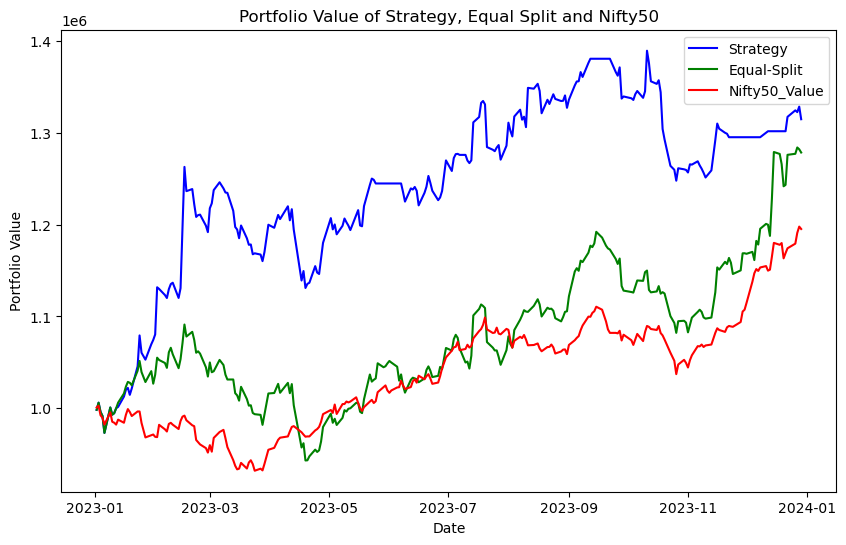

In [375]:
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(result_df.index, result_df['Portfolio Value'], label='Strategy', color='blue')  # Line for Column1
plt.plot(result_df.index, result_df['NS Portfolio Value'], label='Equal-Split', color='green')  # Line for Column2
plt.plot(result_df.index, result_df['Nifty50_Value'], label='Nifty50_Value', color='red')  # Line for Column3

# Adding title and labels
plt.title('Portfolio Value of Strategy, Equal Split and Nifty50')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')

# Show legend
plt.legend()

# Display the plot
plt.show()

The max drawdown is -1514057.1399040222 or -28.07%


<Figure size 1000x500 with 0 Axes>

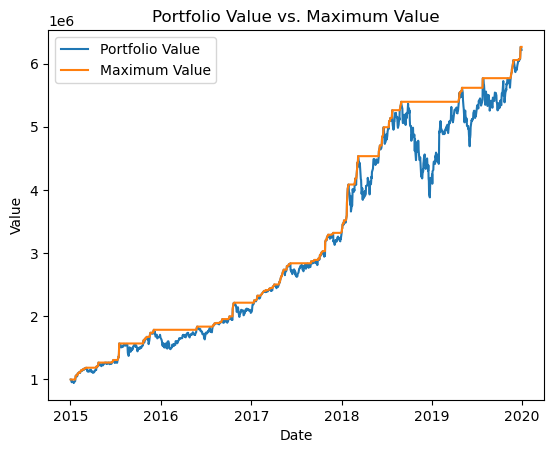

<Figure size 1000x500 with 0 Axes>

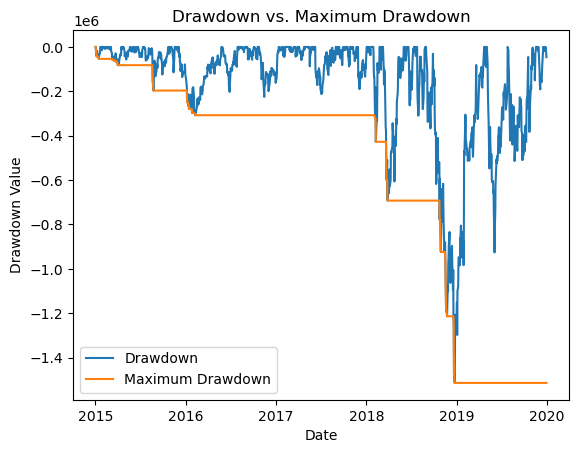

In [22]:
# Cumulative Max
result_df['Maximum Value'] = result_df['Portfolio Value'].cummax()

# Store the differences in a new colum "drawdowns"
# Note that we are calculating the drawdowns from cumsum of returns which is already in percentage.
result_df['Drawdown'] = result_df['Portfolio Value'] - result_df['Maximum Value']
result_df['Drawdown (%)'] = result_df['Drawdown']/result_df['Maximum Value']
result_df['Maximum Drawdown'] = result_df['Drawdown'].cummin()

# The maximum difference is refered as "Drawdown"
max_drawdown = result_df['Drawdown'].min()
max_drawdown_percent = result_df['Drawdown (%)'].min()
print("The max drawdown is", max_drawdown, "or", str(round(max_drawdown_percent*100,2))+"%")

#Visualise how these two look like
plt.figure(figsize=(10, 5))
result_df[['Portfolio Value', 'Maximum Value']].dropna().plot()
plt.xlabel('Date')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.title('Portfolio Value vs. Maximum Value')  # Adding a title for clarity
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
result_df[['Drawdown', 'Maximum Drawdown']].dropna().plot()
plt.xlabel('Date')  # X-axis label
plt.ylabel('Drawdown Value')  # Y-axis label
plt.title('Drawdown vs. Maximum Drawdown')  # Adding a title for clarity
plt.legend()
plt.show()